# Retail Rocket - Anonymous e-commerce site
## Buy or not buy

Retail rocket provided an anonymous [data set]() of an e-commerce site web activity to Kaggle for analysis. Three main data sets were provided; events, item properties, and item category tree.

1. **events** - The behaviorail event of each visitor to the site. Three different types of events were tracked, view, add to cart, and transaction (or buy).
2. **item properties** - Time series in weekly buckets of the item properties. The item properties can change over time, and thus the property of when the visitor interacted with the item is tracked.
3. **category tree** - A hierarchal data set relating category to parent category. This data is not utilized in this anlysis.

The data set is from an actual e-commerce site, and Retail Rocket anonymized many significant parts of the data. However, the category ID, but not the category name, and item availability was not anonymized. Some of the more interesting parts of the data, such as price and discount, were anonymized, which limited some more interesting type of analysis. My analysis focused on splitting the event data into individual sessions and attempting to classify whether or not a previous session will predict whether or not the next session will result in a buy or not.

First, let's import custom libraries to perform the analysis.

In [41]:
import data_transformation # loads and transform the raw csv data into data frames which can be used for analysis
import create_features # generates the features which will be utilized for classification
import model_selection # runs the clas`bsification models

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

%config InlineBackend.figure_format = 'png'

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [3]:
%load_ext autoreload
%autoreload 2

### Data Loading

The events data set was a dump of site activty from May - September 2015. There was no indication of a session for each visitor, so the session for each visiotr had to be calculated. A new session was calcualted and "started" each time there was a delay of at least 30 minutes (configurable) between events.

In [4]:
print(f'The session limit is set to {data_transformation.SESSION_TIME_LIMIT} minutes.')

The session limit is set to 30 minutes.


Let's load the events data.

In [5]:
events = data_transformation.load()

Total number of events: 2,756,101

Session calcualted and sequenced.

Added category and item availability property.


In [6]:
print(f'Number of unique items: {len(events.itemid.unique()):,}')
print(f'Number of unique visitors: {len(events.visitorid.unique()):,}')
print(f'Events start at {events.local_date_time.min():%m-%d-%Y} and ends at {events.local_date_time.max():%m-%d-%Y}')
events.sample(10)

Number of unique items: 235,061
Number of unique visitors: 1,407,580
Events start at 05-02-2015 and ends at 09-17-2015


,timestamp,visitorid,event,itemid,transactionid,local_date_time,minutes_since_prev_event,session_id,seq,categoryid,available
1338123,1436302686197,310759,view,447987,NaN,2015-07-07 13:58:06.197,0.095833,310759_78069,9.0,NaN,NaN
1649290,1437501181900,1254532,view,398883,NaN,2015-07-21 10:53:01.900,0.000000,1254532_1,1.0,NaN,NaN
1864309,1438230319036,440406,view,84773,NaN,2015-07-29 21:25:19.036,0.000000,440406_1,1.0,53,1.0
866476,1434317188460,1407335,view,71952,NaN,2015-06-14 14:26:28.460,0.545267,1407335_1,1.0,973,0.0
865802,1434314720384,828245,view,341333,NaN,2015-06-14 13:45:20.384,0.000000,828245_1,1.0,1263,1.0
1376252,1436428827368,703922,view,254888,NaN,2015-07-09 01:00:27.368,2.621250,703922_1,1.0,1429,1.0
1626636,1437418511459,833064,view,260404,NaN,2015-07-20 11:55:11.459,0.000000,833064_1,1.0,730,0.0
1245759,1435889700975,271126,view,295782,NaN,2015-07-02 19:15:00.975,0.000000,271126_1,1.0,29,0.0
1620021,1437401640061,736018,view,55925,NaN,2015-07-20 07:14:00.061,0.600583,736018_1,1.0,1018,1.0
1994946,1438827743462,879315,view,458803,NaN,2015-08-05 19:22:23.462,0.000000,879315_1,1.0,1503,1.0


The full data set is rather large. We are going to reduce the data set to analyze the first two sessions for each visitor. The second session will be the observation data set, and the first session will be utilized to generate features to predict whether or not the second session will result in a buy or not.

In [7]:
obs, prior_obs = data_transformation.create_observations(events, 2)

In [8]:
buy_percent = prior_obs[prior_obs.buy_event == 1].shape[0] / prior_obs.shape[0]
print(f'Precentage of first session which results in a buy are {buy_percent:.2%}')
prior_obs.head()

Precentage of first session which results in a buy are 1.21%


,session_id,seq,buy_event,visitor_id
0,1000001_1,1.0,0,1000001
2,1000007_1,1.0,0,1000007
4,1000042_1,1.0,0,1000042
6,1000057_1,1.0,0,1000057
8,1000067_1,1.0,0,1000067


Historically, very fey sessions results in a buy transaction. The conversion rate is also not great at 1.21%, with the 2018 average around 2-3% based on this [article](https://www.smartinsights.com/ecommerce/ecommerce-analytics/ecommerce-conversion-rates/). There is potential for improvement for this company and a great question to answer is who will buy or not buy next. If the not buy can be accurately identifed, then effective ad campaigns can be developed to help convert the not buy into a buy.

### Feature generation

The features we will generate will be calculated from the previous session and are the following,

1. Count of views
2. Length of session
3. Number of unique items viewed
4. Number of add to cart events
5. Number of transactions
6. Average item availability, e.g. if 3 pages were viewed and 2 out of the 3 items were available, then item availability is 66%. 

In [9]:
feature_df = create_features.gen_features(events, prior_obs, obs)

feature_df.sample(10)

,session_id,seq,buy_event,visitor_id,view_count,session_length,item_views,add_to_cart_count,transaction_count,avg_avail
2781,1019335_256360,2.0,0,1019335,1.0,0.000000,1.0,0.0,0.0,1.000000
38444,1270618_318686,2.0,0,1270618,2.0,16.794783,1.0,0.0,0.0,1.000000
157316,831599_209027,2.0,0,831599,1.0,0.000000,1.0,0.0,0.0,0.000000
7615,1052939_264483,2.0,0,1052939,1.0,0.000000,1.0,0.0,0.0,1.000000
101641,4428_1143,2.0,0,4428,2.0,0.517267,2.0,0.0,0.0,1.000000
18969,1132889_284840,2.0,0,1132889,3.0,11.951233,3.0,0.0,0.0,1.000000
29305,120674_30661,2.0,0,120674,1.0,0.000000,1.0,0.0,0.0,0.000000
74343,252093_63897,2.0,0,252093,2.0,14.356933,2.0,0.0,0.0,0.000000
8012,1055773_265101,2.0,0,1055773,3.0,2.389200,3.0,0.0,0.0,0.333333
107769,485447_121742,2.0,0,485447,1.0,0.000000,1.0,0.0,0.0,1.000000


All features are calculated and we can now generate the training and test data sets. The train/test split will be 75/25. The buy population is very small, and thus stratifed sampling will be used when generating the train and test data sets. Lastly, the train data set will be upsampled utilizing SMOTE for model selection.

In [10]:
X, y, X_train, X_test, y_train, y_test = model_selection.create_Xy(feature_df)

In [11]:
X_train.describe()

,view_count,session_length,item_views,add_to_cart_count,transaction_count,avg_avail
count,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000
mean,2.654698,6.620509,2.010979,0.296388,0.071502,0.724582
std,4.626543,18.092930,3.325323,0.914663,0.467081,0.425255
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.333333
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,2.688323,5.573479,2.000000,0.000000,0.000000,1.000000
max,132.000000,391.790017,118.000000,44.000000,16.000000,1.000000


In [12]:
y_train.describeribe()

,0
count,208854.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Model selection

We will now train 2 different types of models, Gradient Boost, and Random Forrest. Previous experimenting found these two models provided generally provided better fits. The time to run these models is significant, but the `cv_models` function can be extended to run other models. A 10-fold stratified cross validation will be performed and paramters will be tuned using BayesianSearch optimization. The metric utilized for model selection will be AUC. AUC was chosen to help distinguish which model can generally classify the training data set better.

In [ ]:
results = model_selection.cv_models(X_train, y_train, n_iters=10)

In [25]:
features = ['view_count', 'session_length', 'item_views', 'add_to_cart_count',
   'transaction_count', 'avg_avail']

for k, v in results.items():
    print(f'{k} Summary')
    print()
    print(f'Best out-of-sample AUC score: {v.best_score_}')
    print()
#     print(f'Feature Importance:')
#     for f, i in zip(features, v.best_estimator_.feature_importances_):
#         print(f'{f}: \t {i:.2%}')
#     print()
    print('----------------------------')
    pickle.dump( v.best_estimator_, open( f"../data/best_{k}_model.pkl", "wb" ) )

Gradient Boost Summary

Best out-of-sample AUC score: 0.8575232136022268

----------------------------
Random Forest Summary

Best out-of-sample AUC score: 0.7797512302557211

----------------------------


The Gradient Boosted model appears to provide the better fit based on the best out of sample AUC score in the 10-fold cross validation and with the parameters tuned with Bayesian Search. Let's now review the two model's parameters and plot the ROC curve of the two models.

In [23]:
results['Gradient Boost'].best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7206041341533307, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=456,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)

In [24]:
results['Random Forest'].best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=265, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [18]:
from sklearn.metrics import roc_curve, auc

In [ ]:
y_gb_score = results['Gradient Boost'].best_estimator_.predict_proba(X_train)[:,1]
y_rf_score = results['Random Forest'].best_estimator_.predict_proba(X_train)[:,1]

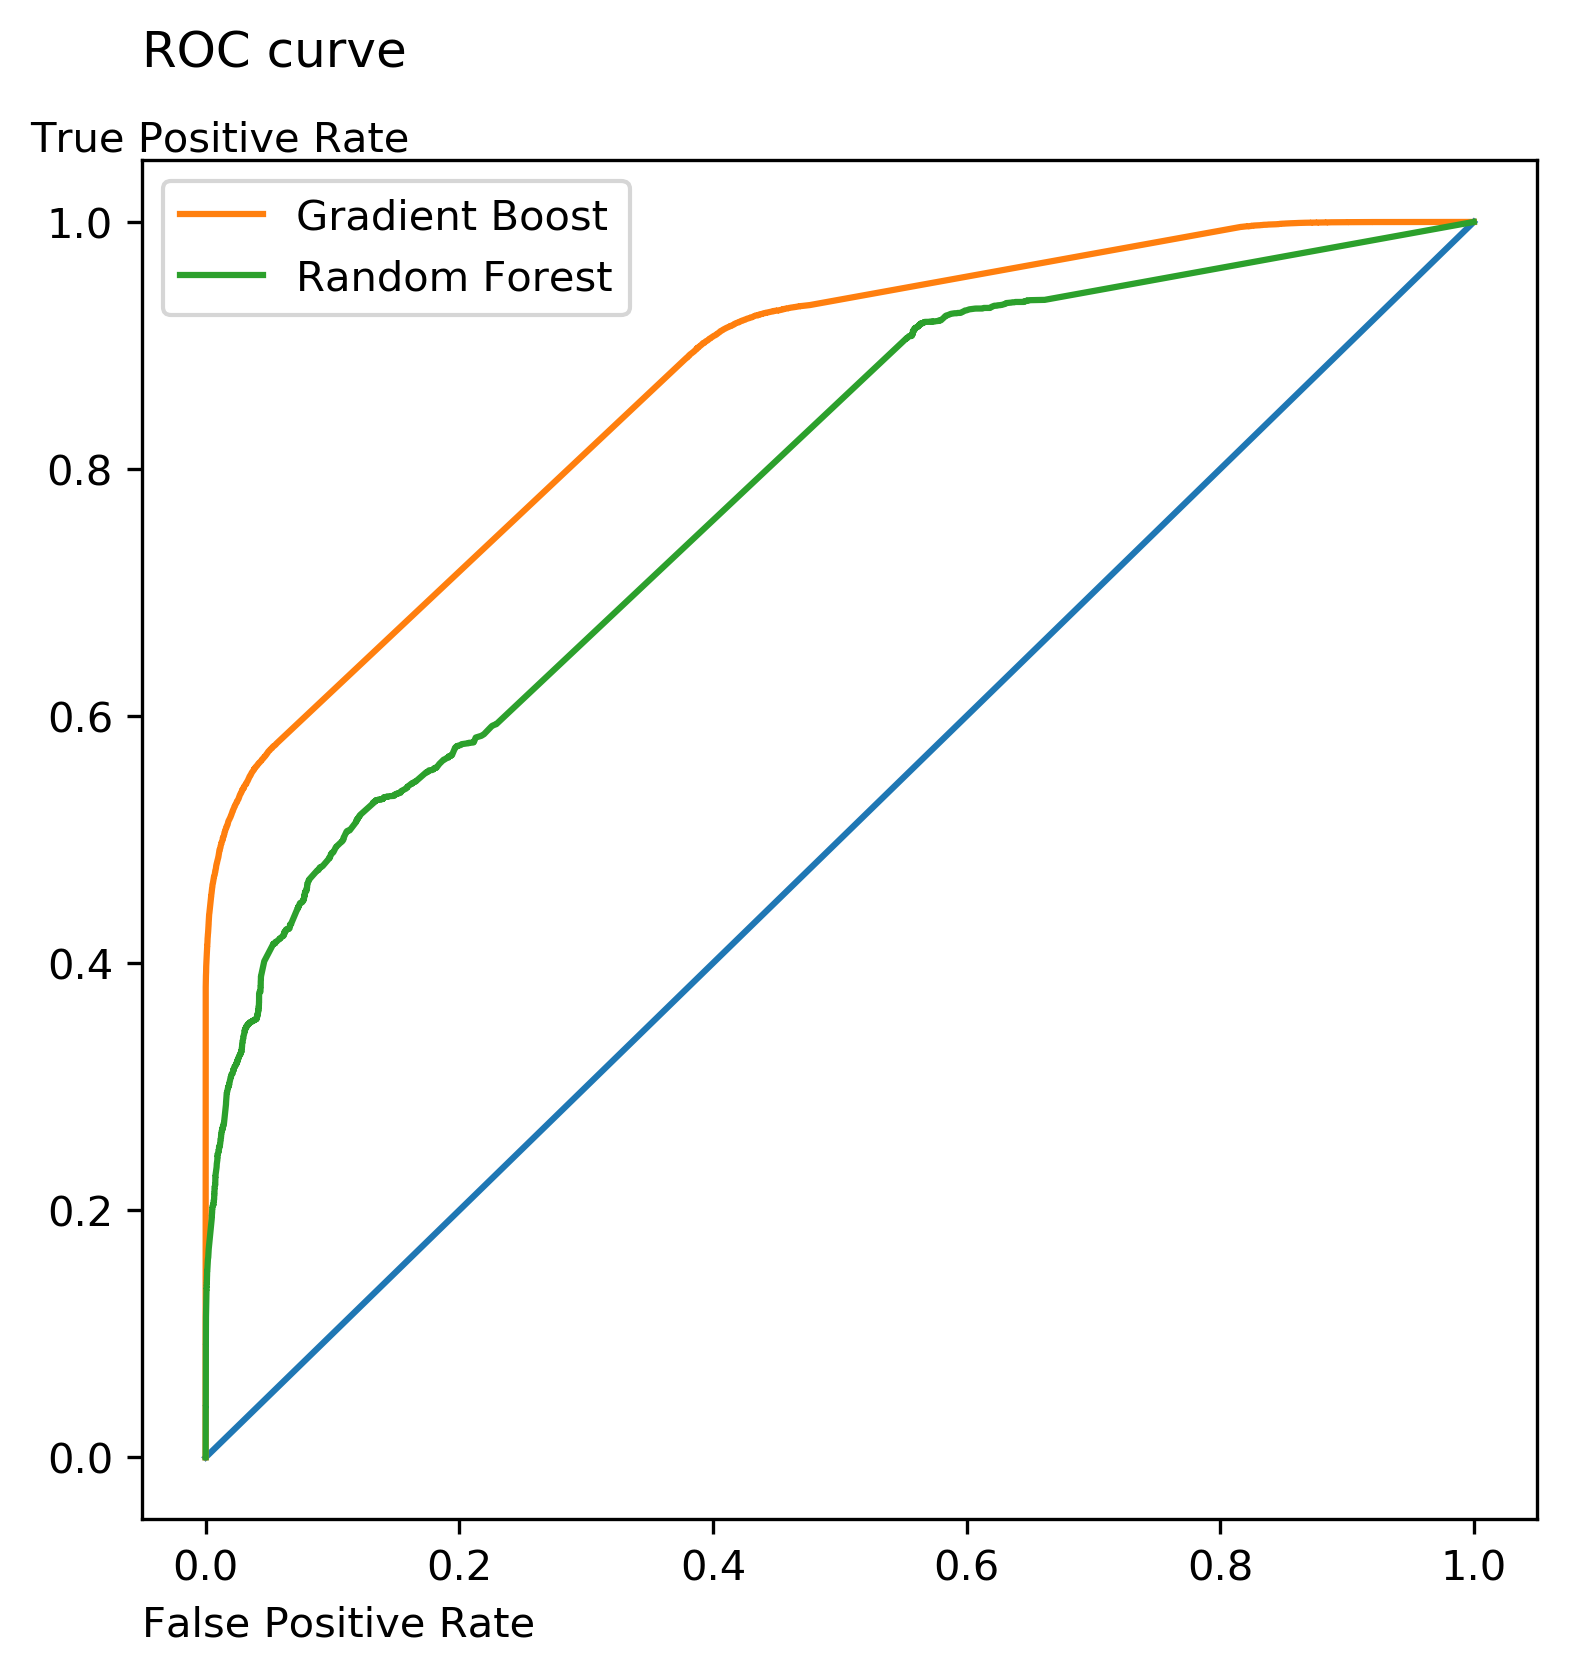

In [72]:
fpr_gb, tpr_gb, _ = roc_curve(y_train, y_gb_score)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_rf_score)

# roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6,6))
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr_gb, tpr_gb, label='Gradient Boost')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.legend()

title_style = {
    'position':(0,1.05),
    'horizontalalignment': 'left'
}

plt.xlabel('False Positive Rate', {
        'horizontalalignment':'left', 
        'fontweight':'ultralight', 
        'position':(0,0)})

plt.ylabel('True Positive Rate', {
    'horizontalalignment':'left', 
    'fontweight':'ultralight', 
    'position':(-0.5,1),
    'rotation':'horizontal'
    })
plt.title('ROC curve', title_style );

The Gradient Boost model performs better than the Random Forest model. Let's now look at the feature importance for the two models. 

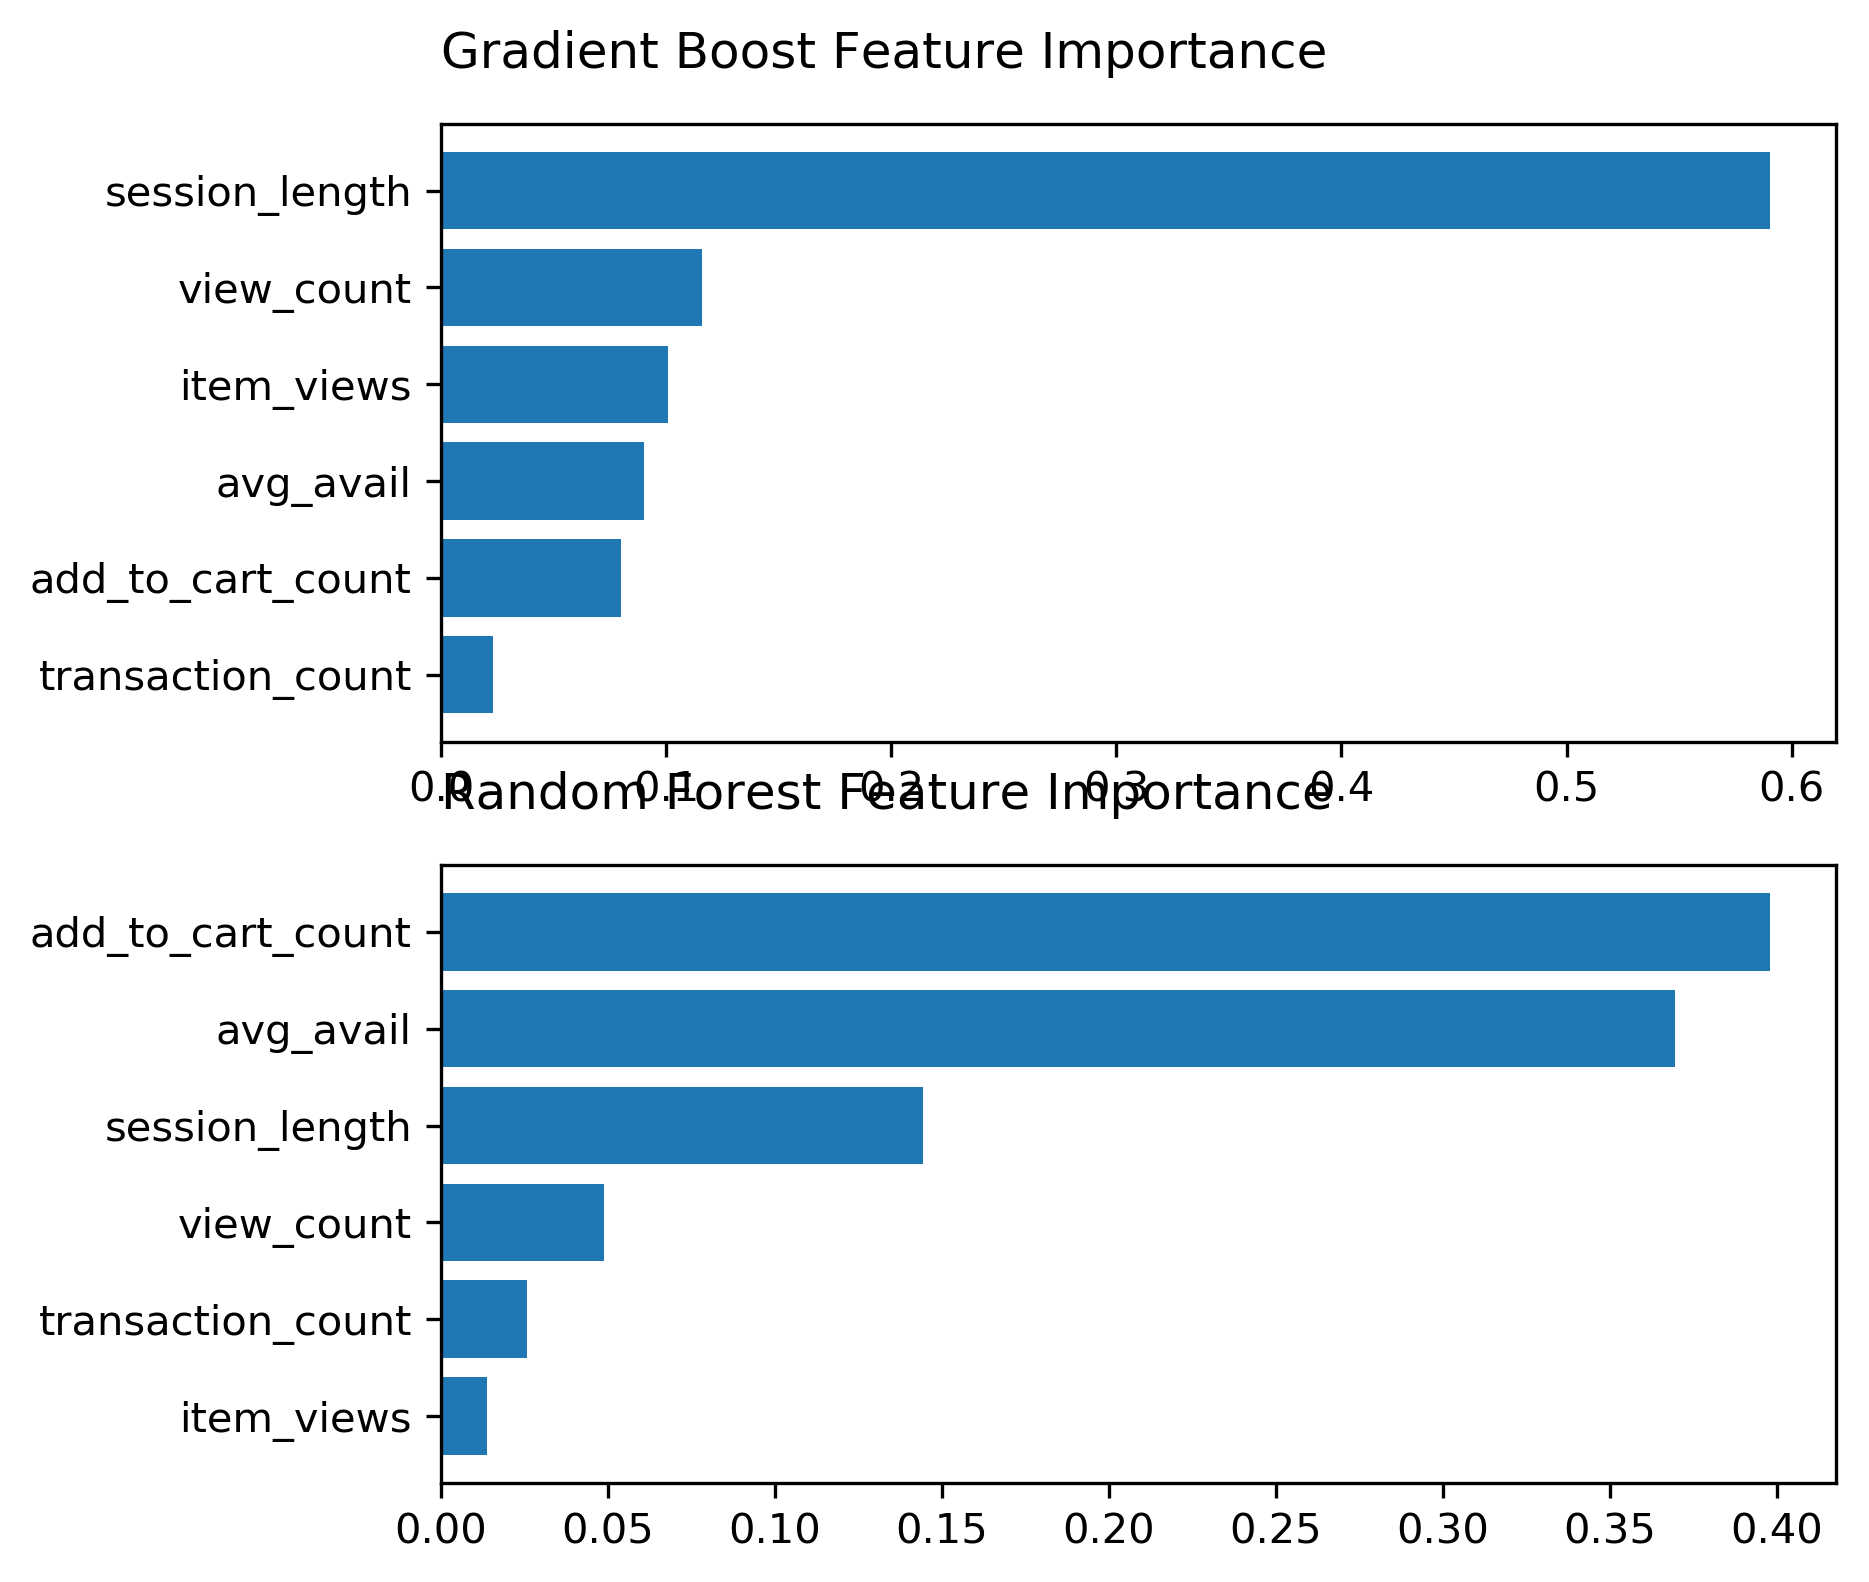

In [99]:
def plot_feature_performance(model, features, title_label):    
    feature_importance_df = pd.DataFrame(data={'features': features, 'importance': model.feature_importances_})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)
    plt.barh(feature_importance_df.features, feature_importance_df.importance)
    plt.title(title_label, title_style);

gb_model = results['Gradient Boost'].best_estimator_
rf_model = results['Random Forest'].best_estimator_

plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plot_feature_performance(gb_model, features, 'Gradient Boost Feature Importance')
plt.subplot(2,1,2)
plot_feature_performance(rf_model, features, 'Random Forest Feature Importance')


Let's now see if there is a significant impact on reducing the number of features in the Gradient Boost model.

In [97]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

In [96]:
gb_model.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7206041341533307, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=456,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)

In [98]:
gb_feature_importance = gb_model.feature_importances_

thresholds = np.sort(gb_feature_importance)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(gb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7206041341533307, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=456,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)
    
    selection_model.fit(select_X_train, np.ravel(y_train))
    # eval model
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_train)
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_test, predictions)
    score = selection_model.score(select_X_train, y_train)
    print(f'Thresh={thresh:.3}, n={select_X_train.shape[1]}, AUC: {score:.3}')
# Don't forget to re-fit on the eventual feature space

Thresh=0.023, n=6, AUC: 0.761
Thresh=0.0799, n=5, AUC: 0.759
Thresh=0.0902, n=4, AUC: 0.752
Thresh=0.101, n=3, AUC: 0.73
Thresh=0.116, n=2, AUC: 0.706
Thresh=0.59, n=1, AUC: 0.663


The AUC change is minimal from using all 6 features down to 4. It could be advantageous to have a less complex model with a similar predictive power. The 2 features which will be dropped are the number of add to cart events and transaction events during the previous session.

1. Need to plot the ROC curve of each of the best models.
2. Need to say which model is best
3. Need to think about cost benefit analysis on where to set the probability
4. Report some metric on test data set